In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os

os.listdir("/kaggle/input")


['brain-tumor-mri-dataset']

In [2]:
os.listdir("/kaggle/input/brain-tumor-mri-dataset")


['Training', 'Testing']

In [3]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [5]:
tf = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])


In [6]:
DATASET_PATH = "/kaggle/input/brain-tumor-mri-dataset"

train_dl = DataLoader(
    datasets.ImageFolder(f"{DATASET_PATH}/Training", tf),
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_dl = DataLoader(
    datasets.ImageFolder(f"{DATASET_PATH}/Testing", tf),
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(train_dl.dataset.classes)


['glioma', 'meningioma', 'notumor', 'pituitary']


In [7]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(128 * 16 * 16, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 4)
).to(device)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)


In [10]:
epochs = 25

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_dl):.4f}")


Epoch [1/25] - Loss: 0.8021
Epoch [2/25] - Loss: 0.5144
Epoch [3/25] - Loss: 0.4355
Epoch [4/25] - Loss: 0.3821
Epoch [5/25] - Loss: 0.3292
Epoch [6/25] - Loss: 0.3022
Epoch [7/25] - Loss: 0.2638
Epoch [8/25] - Loss: 0.2349
Epoch [9/25] - Loss: 0.2198
Epoch [10/25] - Loss: 0.1868
Epoch [11/25] - Loss: 0.1586
Epoch [12/25] - Loss: 0.1474
Epoch [13/25] - Loss: 0.1308
Epoch [14/25] - Loss: 0.1068
Epoch [15/25] - Loss: 0.0980
Epoch [16/25] - Loss: 0.0869
Epoch [17/25] - Loss: 0.0830
Epoch [18/25] - Loss: 0.0687
Epoch [19/25] - Loss: 0.0671
Epoch [20/25] - Loss: 0.0537
Epoch [21/25] - Loss: 0.0539
Epoch [22/25] - Loss: 0.0527
Epoch [23/25] - Loss: 0.0396
Epoch [24/25] - Loss: 0.0452
Epoch [25/25] - Loss: 0.0417


In [11]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 96.41%


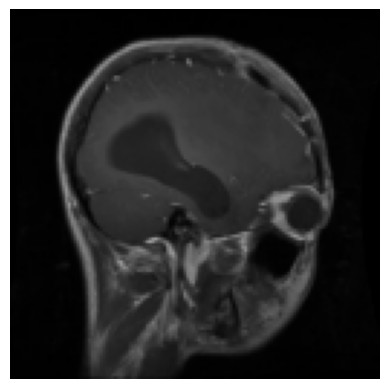

Predicted: glioma
Actual: glioma


In [12]:
from torchvision.transforms.functional import to_pil_image

model.eval()

idx = random.randrange(len(test_dl.dataset))
img, label = test_dl.dataset[idx]

unnorm = img * 0.5 + 0.5

plt.imshow(to_pil_image(unnorm))
plt.axis("off")
plt.show()

with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device)).argmax(1).item()

class_names = test_dl.dataset.classes
print("Predicted:", class_names[pred])
print("Actual:", class_names[label])


In [13]:
torch.save(model.state_dict(), "/kaggle/working/brain_cnn.pth")
print("Model saved")


Model saved


In [4]:
!ls /kaggle/working
